<a href="https://colab.research.google.com/github/snifferchess/4thEdition/blob/master/trascritor_videos_youtube.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Para Transcrever Vídeos Do YouTube.<p>
Criação Daniel Dias da Comunidade Sandeco https://www.youtube.com/@canalsandeco<p>
Site: www.inarte.com.br<p>
Email: inarte@gmail.com <p>
<p>
LEIA COM ATENÇÃO
<P>
Como o uso da GPU T4 é gratuito, ele tem um limite de uso, portanto procure fazer pausas de 3 a 5 dias quando o limite for atingido e não estiver mais fazendo as transcrições.<p><p>
Não Esqueça de Fazer o Donwload do Seu Arquivo Quando Terminar!<p><p>
Selecione Uma Instância Com GPU T4 do Lado Direito Superior (Opções Adicionais de Conexão) Antes de Iniciar a Execução dos Códigos.<p>
Procure do lado direito superior a seta para baixo e altere o ambiente de execussão com GPU - T4.<p>

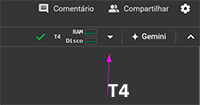


In [ ]:
# Primeiramente, instale as dependências. Aguarde a instalação completa das dependências até o final da  instalação in formando que foi bem sucedida.
!pip install yt-dlp
!pip install git+https://github.com/openai/whisper.git
!pip install deep-translator langdetect tqdm numpy
print("Todas as Dependências Foram Instaladas com Sucesso!")
print("Pode Executar o Próximo Bloco de Código!")

In [ ]:
# Importe as blibliotecas
import subprocess
import whisper
import os
import torch
from deep_translator import GoogleTranslator
from langdetect import detect
import yt_dlp
from tqdm import tqdm
import numpy as np

In [ ]:
# Função para obter o título do vídeo e o nome do canal usando yt-dlp
def get_video_info(url):
    ydl_opts = {
        'quiet': True,
        'skip_download': True,
        'force_generic_extractor': True,
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=False)
        title = info.get('title', 'unknown_title')
        channel = info.get('uploader', 'unknown_channel')
        video_id = info.get('id', 'unknown_id')
        return title, channel, video_id

# Função para dividir o texto em partes menores
def split_text(text, max_length):
    words = text.split(' ')
    current_length = 0
    current_part = []
    parts = []

    for word in words:
        if current_length + len(word) + 1 > max_length:
            parts.append(' '.join(current_part))
            current_part = [word]
            current_length = len(word) + 1
        else:
            current_part.append(word)
            current_length += len(word) + 1

    if current_part:
        parts.append(' '.join(current_part))

    return parts



Cole o link do Video após executar o próximo bloco de comando!

In [ ]:
# Solicita o link do vídeo ao usuário
video_url = input("Cole o link do vídeo: ")

No final do próximo bloco vai aparecer baixando o modelo Whisper, aguarde o terminio para executar o bloco posterior a ele!!

In [ ]:
# Obtém o título, nome do canal e o ID do vídeo
video_title, channel_name, video_id = get_video_info(video_url)
print(f'Título do vídeo: {video_title}')
print(f'Nome do canal: {channel_name}')

# Monta a linha de comando como uma lista de argumentos
output_template = f"{video_id}.%(ext)s"
command = ['yt-dlp', '-x', '-f', 'bestaudio', '--audio-format', 'mp3', '-o', output_template, video_url]

# Executa a linha de comando para baixar o áudio
subprocess.run(command, check=True)

# Lista os arquivos no diretório atual para verificar se o arquivo MP3 foi baixado
print("Arquivos no diretório atual após o download:")
print(os.listdir('.'))

# Encontra o arquivo MP3 baixado
output_filename = None
for file in os.listdir('.'):
    if file.startswith(video_id) and file.endswith('.mp3'):
        output_filename = file
        break

# Verifica se o arquivo MP3 foi encontrado
if output_filename:
    print(f"Arquivo MP3 encontrado: {output_filename}")

    # Renomeia o arquivo MP3 para incluir o título do vídeo e o nome do canal
    safe_video_title = "".join([c if c.isalnum() else "_" for c in video_title])
    safe_channel_name = "".join([c if c.isalnum() else "_" for c in channel_name])
    new_output_filename = f"{safe_channel_name}_{safe_video_title}.mp3"
    os.rename(output_filename, new_output_filename)
    output_filename = new_output_filename

    # Carrega o modelo Whisper com suporte a GPU
    model = whisper.load_model('medium', device="cuda")
    print("Aguarde o carregamento total do modelo whisper para dar continuidade na próxima cellula de código!")


Neste último bloco de código é onde é feito a transcrição e tradução do texto, isso leva um tempo tenha pasciência!<p>
Um texto vai avisar quando estiver terminado!

In [ ]:
    # Carrega o áudio
    audio = whisper.load_audio(output_filename)
    sample_rate = whisper.audio.SAMPLE_RATE
    duration = len(audio) / sample_rate

    # Transcreve o arquivo de áudio em segmentos
    segments = np.array_split(audio, int(duration // 30) + 1)

    all_text = ""

    print("Transcrevendo áudio...")
    for segment in tqdm(segments, desc="Transcrição", unit="segmento"):
        segment_audio = whisper.pad_or_trim(segment)
        mel = whisper.log_mel_spectrogram(segment_audio).to(model.device)
        options = whisper.DecodingOptions(language="en")
        result = whisper.decode(model, mel, options)
        all_text += result.text + " "

    original_text = all_text.strip()
    print("Transcrição original salva.")

    # Detecta o idioma da transcrição
    detected_language = detect(original_text)
    print("Fazendo tradução...")

    # Define a língua de destino para a tradução
    target_language = 'pt' if detected_language == 'en' else 'en'

    # Dividir o texto em partes menores para tradução
    text_parts = split_text(original_text, 5000)
    translated_text = ""

    # Tradução para o idioma de destino
    translator = GoogleTranslator(source=detected_language, target=target_language)
    for part in text_parts:
        translated_text += translator.translate(part) + " "

    translated_text = translated_text.strip()

    # Cria o diretório "textos_transcritos" se não existir
    output_dir = "textos_transcritos"
    os.makedirs(output_dir, exist_ok=True)

    # Salva a transcrição em um arquivo com o nome do título do vídeo e do canal
    transcribed_filename = os.path.join(output_dir, f"{safe_channel_name}_{safe_video_title}.txt")
    with open(transcribed_filename, 'w', encoding='utf-8') as f:
        f.write(f"Transcrição original:\n{original_text}\n\n")
        f.write(f"Transcrição traduzida para {target_language}:\n{translated_text}\n")
    print(f"Trabalho completo. Transcrição salva em: {os.path.abspath(transcribed_filename)}")
    print("O Diretório com o arquivo transcrito vai aparecer em instantes do lado esquerdo na pasta textos_transcritos.")
    print("Clique no icone de pasta abaixo do icone de chave do lado esquerdo para poder vizualizar a pasta.")

    # Libera a memória da GPU
    del model
    torch.cuda.empty_cache()
else:
    print("Nenhum arquivo MP3 encontrado.")

Título do vídeo: 5 Quick Python Projects for Beginners (finish in one day)
Nome do canal: Internet Made Coder
Arquivos no diretório atual após o download:
['.config', 'Internet_Made_Coder_5_Quick_Python_Projects_for_Beginners__finish_in_one_day_.mp3', '4TZ1K8EHT2M.mp3', 'sample_data']
Arquivo MP3 encontrado: 4TZ1K8EHT2M.mp3


100%|█████████████████████████████████████| 1.42G/1.42G [00:17<00:00, 85.3MiB/s]


Transcrevendo áudio...


Transcrição: 100%|██████████| 97/97 [08:37<00:00,  5.34s/segmento]


Transcrição original salva.
Fazendo tradução...
Trabalho completo. Transcrição salva em: /content/textos_transcritos/Internet_Made_Coder_5_Quick_Python_Projects_for_Beginners__finish_in_one_day_.txt
